In [8]:
import os
import sys
sys.path.append('../../')

import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
import swifter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta
from tqdm import tqdm, tqdm_notebook
from category_encoders import TargetEncoder
import core.config as conf

In [9]:
tqdm_notebook().pandas()

/opt/anaconda3/envs/NH/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

## 01. Train Data Load

In [12]:
## load preprocessing data (past_d)
# train_df = pd.read_csv('./result/train_past_d.csv')
# test_df = pd.read_csv('./result/test_past_d.csv')
# train_df = pd.read_csv('./result/train_past_d(2).csv')
# test_df = pd.read_csv('./result/test_past_d(2).csv')
# train_df = pd.read_csv('./result/train_past_d(3).csv')
# test_df = pd.read_csv('./result/test_past_d(3).csv')
# train_df = pd.read_csv('./result/tmp_train.csv')
# test_df = pd.read_csv('./result/tmp_test.csv')
train_df = pd.read_csv('./result/train_data(new_past_d,new_stk_data, new_external_data, nsi).csv')
test_df = pd.read_csv('./result/test_data(new_past_d,new_stk_data, new_external_data, nsi).csv')

In [13]:
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [14]:
train_df

,act_id,iem_cd,byn_dt,hold_d,past_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,...,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change,date,nsi
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,120.750000,2,6,4,2,2,...,2654683.0,-0.009434,3.057820e+03,587925.989405,595956.222494,579696.013040,595411.790546,0.013545,20190321,110.22
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,23.250923,2,6,4,2,2,...,9399085.0,0.002558,6.215593e+05,9806.215159,10083.665037,9533.344743,10003.691117,0.026670,20190327,111.06
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,58.914160,2,6,4,2,2,...,1848.0,0.000000,8.282941e+06,45025.487368,45494.950285,44570.081500,45170.081500,0.012765,20190320,108.19
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,21.489474,2,6,4,2,2,...,145717.0,-0.022676,2.900570e+05,24804.080685,25477.752241,24192.547677,24917.685412,0.021596,20190326,111.85
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,41.692308,2,6,4,2,2,...,1292799.0,-0.001035,2.677373e+05,5925.521597,6054.246129,5792.220864,5912.465363,0.021279,20190611,100.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,32.022831,2,3,2,1,2,...,25117828.0,0.298450,2.364029e+05,85036.614173,86614.041995,83327.690289,84882.808399,0.020508,20200130,108.11
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,23.487805,2,3,2,1,2,...,99859.0,-0.019920,6.442973e+04,15114.947826,15477.109783,14766.867391,15119.502174,0.021951,20201217,119.96
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,8.906250,2,3,2,1,2,...,63304.0,-0.035714,1.074191e+06,1879.232102,1920.221709,1846.302540,2143.690531,0.012190,20201007,113.57
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,31.100000,2,3,2,1,2,...,351186.0,-0.001340,1.513158e+06,50502.000000,51475.333333,49558.000000,50268.666667,0.023183,20200914,106.32


In [8]:
train_df[train_df['hist_d'] == train_df['hold_d']*0.6]

,act_id,iem_cd,byn_dt,hold_d,past_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,...,aet_amt_change,open_d,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,23.250923,2,6,4,2,2,...,152500.0,783.0,9399085.0,0.002558,6.215593e+05,9806.215159,10083.665037,9533.344743,10003.691117,0.026670
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,58.914160,2,6,4,2,2,...,440500.0,27400.0,1848.0,0.000000,8.282941e+06,45025.487368,45494.950285,44570.081500,45170.081500,0.012765
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,21.489474,2,6,4,2,2,...,152450.0,4415.0,145717.0,-0.022676,2.900570e+05,24804.080685,25477.752241,24192.547677,24917.685412,0.021596
5,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A037070,20190325,2,23.903704,2,6,4,2,2,...,84300.0,32213.0,1290376.0,0.000000,3.722654e+05,7270.774246,7456.814181,7109.348818,7270.449878,0.020633
9,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A078020,20190702,145,59.403846,2,6,4,2,2,...,197264.0,2460.0,5413466.0,0.000000,8.851297e+04,8510.603097,8587.958435,8403.541157,8499.963325,0.009832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,32.022831,2,3,2,1,2,...,84700.0,13050.0,25117828.0,0.298450,2.364029e+05,85036.614173,86614.041995,83327.690289,84882.808399,0.020508
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,23.487805,2,3,2,1,2,...,52900.0,3745.0,99859.0,-0.019920,6.442973e+04,15114.947826,15477.109783,14766.867391,15119.502174,0.021951
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,8.906250,2,3,2,1,2,...,81600.0,3525.0,63304.0,-0.035714,1.074191e+06,1879.232102,1920.221709,1846.302540,2143.690531,0.012190
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,31.100000,2,3,2,1,2,...,87000.0,3785.0,351186.0,-0.001340,1.513158e+06,50502.000000,51475.333333,49558.000000,50268.666667,0.023183


In [15]:
test_df

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change,date,nsi
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,1930122.0,-0.014981,1.859878e+06,13298.084760,13491.597392,13103.480033,13290.309698,0.014526,20200522,106.54
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,1783575.0,-0.015448,3.079929e+05,30852.931540,31516.180929,30064.927465,31274.595762,0.017717,20190823,102.73
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,241315.0,-0.015823,1.645605e+05,30529.807692,31236.675824,29781.730769,30427.060440,0.023442,20200611,109.37
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,6615258.0,0.091787,7.292597e+05,2935.981255,3011.268134,2858.189894,2932.819071,0.025209,20200120,121.26
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,523303.0,0.002157,1.513158e+06,50502.000000,51475.333333,49558.000000,50268.666667,0.023183,20201217,119.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,...,NaN,NaN,9.611750e+04,256808.883456,259797.473513,254081.499593,256982.885086,0.012186,20201127,124.28
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,...,NaN,NaN,7.016480e+04,8223.781581,8282.868786,8147.864711,8222.860636,0.008042,20200731,121.99
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,...,NaN,NaN,8.560609e+05,1.770270,1.870270,1.405405,952.164865,0.004922,20170704,127.37
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,...,NaN,NaN,3.444963e+04,85423.716381,87124.286879,83760.146699,85415.077425,0.017916,20201215,122.60


In [88]:
path = conf.data_path

In [89]:
# # train_df = pd.read_csv(f'{path}'+'stk_hld_train.csv')
# train_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'stk_hld_train.csv') # 아정

In [90]:
train_df.head()

,act_id,iem_cd,byn_dt,hold_d,past_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,...,aet_amt_change,open_d,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,120.750000,2,6,4,2,2,...,923285.0,10600.0,2654683.0,-0.009434,3.057820e+03,587925.989405,595956.222494,579696.013040,595411.790546,0.013545
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,23.250923,2,6,4,2,2,...,152500.0,783.0,9399085.0,0.002558,6.215593e+05,9806.215159,10083.665037,9533.344743,10003.691117,0.026670
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,58.914160,2,6,4,2,2,...,440500.0,27400.0,1848.0,0.000000,8.282941e+06,45025.487368,45494.950285,44570.081500,45170.081500,0.012765
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,21.489474,2,6,4,2,2,...,152450.0,4415.0,145717.0,-0.022676,2.900570e+05,24804.080685,25477.752241,24192.547677,24917.685412,0.021596
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,41.692308,2,6,4,2,2,...,301566.0,48350.0,1292799.0,-0.001035,2.677373e+05,5925.521597,6054.246129,5792.220864,5912.465363,0.021279


In [91]:
# cus_df = pd.read_csv(f'{path}'+'cus_info.csv')
cus_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'cus_info.csv') # 아정

In [92]:
cus_df.head()

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [93]:
# iem_df = pd.read_csv(f'{path}'+'iem_info_20210902.csv')
iem_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'iem_info_20210902.csv')  # 아정

In [94]:
iem_df.head()

,iem_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


### 종목 Label Encoding

In [95]:
# L_encoder = LabelEncoder()
# L_encoder.fit(iem_df["iem_krl_nm"])

In [96]:
# iem_df['iem_krl_nm'] = L_encoder.transform(iem_df["iem_krl_nm"])

In [97]:
# train_df = pd.merge(left = train_df, right = cus_df, how='left', on='act_id')

In [98]:
# train_df = pd.merge(train_df, iem_df, how='left', on='iem_cd')

## 02. Test Data Load

In [99]:
# test_df = pd.read_csv(f'{path}'+'stk_hld_test.csv')
# test_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'stk_hld_test.csv')  # 아정

In [100]:
# test_df = pd.merge(left = test_df, right = cus_df, how='left', on='act_id')

In [101]:
# test_df = pd.merge(test_df, iem_df, how='left', on='iem_cd')

In [102]:
# test_df.head()

In [103]:
train_df

,act_id,iem_cd,byn_dt,hold_d,past_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,...,aet_amt_change,open_d,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,120.750000,2,6,4,2,2,...,923285.0,10600.0,2654683.0,-0.009434,3.057820e+03,587925.989405,595956.222494,579696.013040,595411.790546,0.013545
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,23.250923,2,6,4,2,2,...,152500.0,783.0,9399085.0,0.002558,6.215593e+05,9806.215159,10083.665037,9533.344743,10003.691117,0.026670
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,58.914160,2,6,4,2,2,...,440500.0,27400.0,1848.0,0.000000,8.282941e+06,45025.487368,45494.950285,44570.081500,45170.081500,0.012765
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,21.489474,2,6,4,2,2,...,152450.0,4415.0,145717.0,-0.022676,2.900570e+05,24804.080685,25477.752241,24192.547677,24917.685412,0.021596
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,41.692308,2,6,4,2,2,...,301566.0,48350.0,1292799.0,-0.001035,2.677373e+05,5925.521597,6054.246129,5792.220864,5912.465363,0.021279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,32.022831,2,3,2,1,2,...,84700.0,13050.0,25117828.0,0.298450,2.364029e+05,85036.614173,86614.041995,83327.690289,84882.808399,0.020508
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,23.487805,2,3,2,1,2,...,52900.0,3745.0,99859.0,-0.019920,6.442973e+04,15114.947826,15477.109783,14766.867391,15119.502174,0.021951
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,8.906250,2,3,2,1,2,...,81600.0,3525.0,63304.0,-0.035714,1.074191e+06,1879.232102,1920.221709,1846.302540,2143.690531,0.012190
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,31.100000,2,3,2,1,2,...,87000.0,3785.0,351186.0,-0.001340,1.513158e+06,50502.000000,51475.333333,49558.000000,50268.666667,0.023183


## 03. Stock Hist

In [105]:
# stk_df = pd.read_csv(f'{path}'+'stk_bnc_hist.csv')
# stk_df_price = pd.read_csv(f'{path}'+'stk_bnc_hist_share_price.csv')
stk_df = pd.read_csv('~/Study/' + conf.data_path[2:] +'stk_bnc_hist.csv')  # 아정
stk_df_price = pd.read_csv('~/Study/' + conf.data_path[2:] +'stk_bnc_hist_end_price.csv')  # 아정

In [107]:
# stk_df.head()

In [109]:
# stk_df_price.head()

In [110]:
stk_df_price.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [111]:
stk_df_price

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,end_price
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0,70700.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0,69500.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0,9590.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0,58000.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0,51400.0
...,...,...,...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200806,A035720,1.0,364000.0,500.0,364000.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200813,A035720,0.0,0.0,500.0,NaN
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200819,A035720,1.0,376500.0,500.0,376500.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200825,A035720,0.0,0.0,500.0,NaN


## 04. Data Preprocessing

### hist d : 

In [112]:
train_df["hist_d"] = train_df["hold_d"]*0.6

In [113]:
# def working_day(s_dt, e_dt) : # 공휴일 제외
#     s_dt = str(s_dt).split('.')[0]
#     e_dt = str(e_dt).split('.')[0]
#     s_dt = s_dt[:4] + '-' + s_dt[4:6] + '-' + s_dt[6:]
#     e_dt = e_dt[:4] + '-' + e_dt[4:6] + '-' + e_dt[6:]
#     return np.busday_count(s_dt, e_dt, weekmask='1111100')

In [114]:
# holiday = pd.read_csv(external_path +'holiday_date.csv')
external_path = conf.external_path
holiday = pd.read_csv('~/Study/' + external_path[2:] +'holiday_date.csv') # 아정

In [115]:
holidays = pd.to_datetime(holiday['date'], infer_datetime_format=True).dt.strftime("%Y-%m-%d")
holidays = list(holidays)
for i in range(len(holidays)):
    tmp = holidays[i].split('-')
    holidays[i] = ''.join(tmp)
holidays = list(map(int, holidays))

In [116]:
def working_day(s_dt, e_dt) : # 공휴일 제외 # 공휴일이 주말인 경우 고려 
    count = 0
    for day in holidays:
        if day >= s_dt and day <= e_dt:
            count += 1
        elif day > e_dt:
            break
        else:
            continue
    s_dt = str(s_dt).split('.')[0]
    e_dt = str(e_dt).split('.')[0]
    s_dt = s_dt[:4] + '-' + s_dt[4:6] + '-' + s_dt[6:]
    e_dt = e_dt[:4] + '-' + e_dt[4:6] + '-' + e_dt[6:]
    w_day = np.busday_count(s_dt, e_dt, weekmask='1111100') # 주말제외
    
    result = w_day - count
    return result

### External Data Featuring
- 종목 별 volume feature 추가

In [117]:
external_path = conf.external_path
print(external_path)

~/2021-nh-bigdata-competition/external/result/


In [118]:
# stk_mean_df = pd.read_csv(external_path+'mean_stockdata.csv')
stk_mean_df = pd.read_csv('~/Study/' + external_path[2:] +'mean_stockdata.csv') # 아정

In [119]:
stk_mean_df['code'] = stk_mean_df.apply(lambda x : 'A' + x['code'], axis = 1)

In [120]:
stk_mean_df

,code,open,high,low,close,volume,change
0,A000020,10628.321108,10875.158924,10395.338223,10611.340668,4.514417e+05,0.001178
1,A000030,13718.842105,13873.710526,13566.907895,14156.565789,1.592198e+06,0.000800
2,A000040,3205.013040,3268.528117,3137.779136,3229.211084,1.243295e+06,-0.000945
3,A000050,13186.233089,13408.596577,12970.257539,13402.982885,3.864996e+04,-0.000098
4,A000060,18285.819071,18510.423798,18045.867971,18283.928280,1.757751e+05,0.000082
...,...,...,...,...,...,...,...
2807,A371470,10585.937500,10747.812500,10474.375000,10595.937500,2.414732e+05,0.007861
2808,A371870,10113.500000,10179.500000,9927.500000,10037.000000,1.963900e+04,0.000063
2809,A372330,10127.000000,10232.000000,9951.000000,10080.000000,8.949426e+05,0.001339
2810,A373490,10156.500000,10307.250000,10123.000000,10264.500000,9.705650e+04,0.016875


In [76]:
# train_df = pd.merge(left = train_df, right = stk_mean_df[['code', 'volume', 'open']], how='left', left_on='iem_cd', right_on = 'code')

In [77]:
# test_df = pd.merge(left = test_df, right = stk_mean_df[['code', 'volume','open']], how='left', left_on='iem_cd', right_on = 'code')

### Target Encoding
종목 별 hold_d를 사용해서 종목 코드를 target encoding

In [123]:
target_encoder = TargetEncoder()

In [124]:
target_encoder.fit(train_df['iem_cd'], train_df['hold_d'])

TargetEncoder(cols=['iem_cd'])

In [128]:
# train_df['iem_cd_te'] = target_encoder.transform(train_df['iem_cd'], train_df['hold_d'])

In [130]:
test_df['iem_cd_te'] = target_encoder.transform(test_df['iem_cd'], test_df['hold_d'])

In [131]:
test_df = test_df.fillna(0)

In [132]:
train_df = train_df.fillna(0)

In [858]:
#target_encoder.transform(train_df['ivs_icn_cd'], train_df['hold_d'])

### past_d 계산
user 별 종목 past_d

In [859]:
# # id_stk_dur_df = pd.read_csv(conf.data_path + 'id_stk_dur_list.csv')
# id_stk_dur_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'id_stk_dur_list.csv') # 아정

In [860]:
# train_df = pd.merge(train_df, id_stk_dur_df[['act_id', 'iem_cd', 'act_past_d_mean']], how = 'left', on = ['act_id', 'iem_cd'])

In [861]:
# test_df = pd.merge(test_df, id_stk_dur_df[['act_id', 'iem_cd', 'act_past_d_mean']], how = 'left', on = ['act_id', 'iem_cd'])

### 투자성향 별 past_d 계산

In [862]:
# # ivs_past_df = pd.read_csv(conf.data_path + 'preprocessing/ivs_past_d_mean.csv')
# ivs_past_df = pd.read_csv('~/Study/' + conf.data_path[2:] + 'preprocessing/ivs_past_d_mean.csv') # 아정

In [863]:
# train_df = pd.merge(train_df, ivs_past_df, how = 'left', on = ['iem_cd', 'ivs_icn_cd'])

In [864]:
# test_df = pd.merge(test_df, ivs_past_df, how = 'left', on = ['iem_cd', 'ivs_icn_cd'])

In [865]:
# train_df = train_df.fillna(0)
# test_df = test_df.fillna(0)

## hist_d

In [866]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

In [867]:
def hist_d_half(buy, hold_d) :
    buy_d = str(buy)
    buy_d = datetime(int(buy_d[:4]), int(buy_d[4:6]), int(buy_d[6:]))
    sell = to_integer(buy_d+timedelta(days=hold_d))
    base = [20160101, 20160630, 20170102, 20170630, 20180102, 20180630, 
            20190102, 20190630, 20200102, 20200630, 20210101]
    for i in range(len(base)) :
        if sell < base[i] :
            if buy > base[i-1] :
                return hold_d*0.6
            else :
                return working_day(buy, base[i-1])

In [868]:
# train_df['hist_d'] = train_df.apply(lambda x : hist_d_half(x['byn_dt'], x['hold_d']), axis = 1)

In [134]:
test_df

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d,iem_cd_te
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,9,5,5,8,418,4,1,1,159.0,22.282632
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,9,5,5,8,2230,10,3,99,354.0,23.076471
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,9,5,5,8,1515,13,2,99,145.0,22.713080
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,9,5,5,8,2681,13,3,99,248.0,17.246094
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,9,5,5,8,2450,13,1,2,10.0,12.968932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,...,5,3,5,2,1369,2,1,1,12.5,22.986667
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,...,5,3,5,2,444,2,99,99,109.0,44.190955
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,...,3,4,3,8,1280,14,3,99,912.0,6.731379
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,...,3,4,3,8,2373,8,2,99,6.5,22.974093


### 종가(end_price) 추가

In [135]:
stk_df_price

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,end_price
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0,70700.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0,69500.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0,9590.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0,58000.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0,51400.0
...,...,...,...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200806,A035720,1.0,364000.0,500.0,364000.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200813,A035720,0.0,0.0,500.0,NaN
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200819,A035720,1.0,376500.0,500.0,376500.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200825,A035720,0.0,0.0,500.0,NaN


In [136]:
stk_df_price = stk_df_price.rename(columns={'bse_dt':'byn_dt'})

In [137]:
stk_df_price

,act_id,byn_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,end_price
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0,70700.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0,69500.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0,9590.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0,58000.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0,51400.0
...,...,...,...,...,...,...,...
2573834,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200806,A035720,1.0,364000.0,500.0,364000.0
2573835,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200813,A035720,0.0,0.0,500.0,NaN
2573836,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200819,A035720,1.0,376500.0,500.0,376500.0
2573837,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,20200825,A035720,0.0,0.0,500.0,NaN


In [138]:
# # train_df = pd.merge(left = train_df, right = stk_df_price, how='left', left_on=['act_id','byn_dt','iem_cd'], right_on = ['act_id', 'byn_dt', 'iem_cd'])
# train_df = pd.merge(left = train_df, right = stk_df_price, how='left', on = ['act_id', 'byn_dt', 'iem_cd'])

In [139]:
test_df = pd.merge(left = test_df, right = stk_df_price, how='left', on = ['act_id', 'byn_dt', 'iem_cd'])

In [140]:
test_df

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d,iem_cd_te,bnc_qty,tot_aet_amt,stk_par_pr,end_price
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,418,4,1,1,159.0,22.282632,300.0,3945000.0,5000.0,13150.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,2230,10,3,99,354.0,23.076471,198.0,2524500.0,500.0,12750.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,1515,13,2,99,145.0,22.713080,138.0,4291800.0,500.0,31100.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,2681,13,3,99,248.0,17.246094,2972.0,6716720.0,500.0,2260.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,2450,13,1,2,10.0,12.968932,10.0,464500.0,100.0,46450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,...,1369,2,1,1,12.5,22.986667,1.0,198500.0,500.0,198500.0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,...,444,2,99,99,109.0,44.190955,50.0,372000.0,5000.0,7440.0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,...,1280,14,3,99,912.0,6.731379,75057.0,3677793.0,100.0,49.0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,...,2373,8,2,99,6.5,22.974093,96.0,11424000.0,2500.0,119000.0


### max_d, bnc_count 추가 (max_d 제외)("max_d"의 배신)

In [142]:
# df1 = pd.read_csv('./result/train_past_d(2).csv')
# df2 = pd.read_csv('./result/test_past_d(2).csv')
# max_d_bnc_count = df1[['act_id', 'iem_cd', 'bnc_count']]
# max_d_bnc_count2 = df2[['act_id', 'iem_cd', 'bnc_count']]
# train_df = pd.merge(train_df, max_d_bnc_count, how = 'left', on = ['act_id', 'iem_cd'])
# test_df = pd.merge(test_df, max_d_bnc_count2, how = 'left', on = ['act_id', 'iem_cd'])
# train_df = train_df.drop_duplicates()
# test_df = test_df.drop_duplicates()

### past_d==0 을 투자성향 별 평균 past_d 로

In [879]:
# train_df['past_d'] = train_df.apply(lambda x : x['ivs_past_d_mean'] if x['past_d'] == 0 else x['past_d'], axis = 1)

### 계좌번호-종목 별 잔고수량, 잔고금액 변동량 (변동량의 평균) 추가

In [155]:
stk_df_change = pd.read_csv('~/Study/' + conf.data_path[2:] +'qty_amt_change.csv')  # 아정
stk_df_change.drop(['Unnamed: 0'], axis = 1, inplace = True)
stk_df_change

,act_id,iem_cd,qty_change,aet_amt_change
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,2.714286,923285.0
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,10.000000,152500.0
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,10.000000,440500.0
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,7.000000,152450.0
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,60.000000,301566.0
...,...,...,...,...
484060,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,1.000000,84700.0
484061,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,2.000000,52900.0
484062,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,15.000000,81600.0
484063,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,2.000000,87000.0


In [156]:
# train_df = pd.merge(left = train_df, right = stk_df_change, how='left', on = ['act_id', 'iem_cd'])
test_df = pd.merge(left = test_df, right = stk_df_change, how='left', on = ['act_id', 'iem_cd'])

In [157]:
test_df

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,stk_dit_cd,past_d,iem_cd_te,bnc_qty,tot_aet_amt,stk_par_pr,end_price,bnc_count,qty_change,aet_amt_change
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,1,159.0,22.282632,300.0,3945000.0,5000.0,13150.0,2,NaN,NaN
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,99,354.0,23.076471,198.0,2524500.0,500.0,12750.0,3,198.00,1.336500e+06
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,99,145.0,22.713080,138.0,4291800.0,500.0,31100.0,4,42.00,1.183550e+06
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,99,248.0,17.246094,2972.0,6716720.0,500.0,2260.0,5,337.00,9.176117e+05
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,2,10.0,12.968932,10.0,464500.0,100.0,46450.0,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,1,6,0,5,...,1,12.5,22.986667,1.0,198500.0,500.0,198500.0,7,1.60,3.368000e+05
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,1,6,0,5,...,99,109.0,44.190955,50.0,372000.0,5000.0,7440.0,10,106.25,8.253750e+05
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,1,4,4,2,...,99,912.0,6.731379,75057.0,3677793.0,100.0,49.0,2,NaN,NaN
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,1,4,4,2,...,99,6.5,22.974093,96.0,11424000.0,2500.0,119000.0,7,104.80,1.360840e+07


#### 외부데이터(종목데이터 - new)

In [159]:
# new_external = pd.read_csv('./result/test_data1009.csv')

In [194]:
# new_external = new_external[['act_id', 'iem_cd', 'byn_dt','open_d', 'volume_d', 'change_d', 'mean_volume', 'mean_open', 'mean_high', 'mean_low', 'mean_close', 'mean_abs_change']]


In [196]:
# train_df = train_df.drop(['open', 'volume'], axis = 1)
# test_df

In [197]:
# test_df2 = pd.merge(test_df, new_external, on=['act_id', 'iem_cd', 'byn_dt'])

In [69]:
# train_df2 = pd.merge(train_df, new_external, on=['act_id', 'iem_cd', 'byn_dt'])

#### train/test 데이터 저장

In [198]:
# test_df2.to_csv('test_data(new_past_d,new_stk_data, new_external_data).csv')

In [889]:
# train_df = pd.read_csv('./result/train_data(new_past_d,new_stk_data).csv')

In [894]:
# train_df['qty_change'].isnull().sum()

0

In [202]:
train_df

,act_id,iem_cd,byn_dt,hold_d,past_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,...,aet_amt_change,open_d,volume_d,change_d,mean_volume,mean_open,mean_high,mean_low,mean_close,mean_abs_change
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A002270,20190321,350,120.750000,2,6,4,2,2,...,923285.0,10600.0,2654683.0,-0.009434,3.057820e+03,587925.989405,595956.222494,579696.013040,595411.790546,0.013545
1,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005070,20190327,19,23.250923,2,6,4,2,2,...,152500.0,783.0,9399085.0,0.002558,6.215593e+05,9806.215159,10083.665037,9533.344743,10003.691117,0.026670
2,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A005930,20190320,1,58.914160,2,6,4,2,2,...,440500.0,27400.0,1848.0,0.000000,8.282941e+06,45025.487368,45494.950285,44570.081500,45170.081500,0.012765
3,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A033270,20190326,75,21.489474,2,6,4,2,2,...,152450.0,4415.0,145717.0,-0.022676,2.900570e+05,24804.080685,25477.752241,24192.547677,24917.685412,0.021596
4,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,A036000,20190611,133,41.692308,2,6,4,2,2,...,301566.0,48350.0,1292799.0,-0.001035,2.677373e+05,5925.521597,6054.246129,5792.220864,5912.465363,0.021279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A253450,20200130,130,32.022831,2,3,2,1,2,...,84700.0,13050.0,25117828.0,0.298450,2.364029e+05,85036.614173,86614.041995,83327.690289,84882.808399,0.020508
681468,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A264450,20201217,8,23.487805,2,3,2,1,2,...,52900.0,3745.0,99859.0,-0.019920,6.442973e+04,15114.947826,15477.109783,14766.867391,15119.502174,0.021951
681469,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A267320,20201007,47,8.906250,2,3,2,1,2,...,81600.0,3525.0,63304.0,-0.035714,1.074191e+06,1879.232102,1920.221709,1846.302540,2143.690531,0.012190
681470,fff9cf3aaffd32dcbf70dce8e5216411f9d38537b477d6...,A293490,20200914,61,31.100000,2,3,2,1,2,...,87000.0,3785.0,351186.0,-0.001340,1.513158e+06,50502.000000,51475.333333,49558.000000,50268.666667,0.023183


In [211]:
test_df2['submit_id']

0        IDX00001
1        IDX00002
2        IDX00003
3        IDX00004
4        IDX00005
           ...   
70591    IDX70592
70592    IDX70593
70593    IDX70594
70594    IDX70595
70595    IDX70596
Name: submit_id, Length: 70596, dtype: object

### Drop Features

In [330]:
# train_df = train_df.drop(['act_id', 'iem_cd', 'code', 'byn_dt', 'mrz_pdt_tp_sgm_cd', 'stk_dit_cd', 'mkt_pr_tal_scl_tp_cd'], axis = 1)

In [17]:
# train_df = train_df.drop(['act_id', 'sell_d', 'iem_cd', 'code', 'byn_dt'], axis = 1)
# train_df = train_df.drop(['act_id', 'iem_cd', 'code', 'byn_dt', 'max_d'], axis = 1)
train_df = train_df.drop(['act_id', 'iem_cd', 'code', 'byn_dt'], axis = 1)

In [18]:
target = train_df['hold_d']

In [19]:
used_features = train_df.columns.drop('hold_d')

In [334]:
# test_df = test_df.drop(['max_d'], axis = 1)

In [335]:
test_df = test_df[used_features]

In [336]:
train_df.columns

Index(['hold_d', 'past_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'open',
       'iem_cd_te', 'ivs_past_d_mean', 'bnc_qty', 'tot_aet_amt', 'stk_par_pr',
       'end_price', 'bnc_count'],
      dtype='object')

In [337]:
test_df.columns

Index(['past_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'hist_d', 'volume', 'open',
       'iem_cd_te', 'ivs_past_d_mean', 'bnc_qty', 'tot_aet_amt', 'stk_par_pr',
       'end_price', 'bnc_count'],
      dtype='object')

### Data Scaling
Train/Test 데이터에 대해 정규화 수행 sklearn의 정규화 함수 이용

- StandardScalar
- MinMaxScalar
- MaxAbsScalar
- RobustScalar

In [338]:
# # 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
# def standard_scaling(df, scale_columns):
#     for col in scale_columns:
#         series_mean = df[col].mean()
#         series_std = df[col].std()
#         df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
#     return df

In [339]:
# # 피처 각각에 대한 scaling을 수행합니다.
# # scale_columns = ['hold_d', 'hist_d', 'volume', 'iem_cd_te', 'act_past_d_mean','ivs_past_d_mean']
# scale_columns = ['hist_d', 'volume', 'iem_cd_te', 'act_past_d_mean','ivs_past_d_mean']
# df = standard_scaling(train_df, scale_columns)

## 05. XGBoost
model : 기본 XGBoost 모델  
xgb_grid : GridSearch libarary를 통해서 model 최적 파라미터 구한 모델  
* 둘 중 하나로 테스트해보면 되는데 xgb_grid는 정확도가 올라가는 대신 시간 매우 오래 걸림

In [340]:
col = train_df.columns

In [341]:
col = col.drop('hold_d')

In [342]:
TARGET = 'hold_d'

In [343]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[col], train_df[TARGET], test_size = 0.2)

In [344]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=8, min_child_weighteta=0.1, subsample=0.7, colsample_bytree=0.8)

#### GridSearch

In [365]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'eta' :[0.05, 0.1],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [1, 2, 4, 6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [366]:
model.fit(X_train, y_train, verbose=False)

[22:46:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_child_weighteta } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_child_weighteta=0.1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [368]:
# xgb_grid.fit(X_train, y_train, verbose=False)

In [369]:
import joblib

In [370]:
joblib.dump(xgb_grid, 'xgb_gridcv.pkl')

['xgb_gridcv.pkl']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

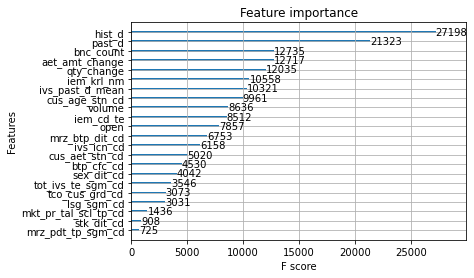

In [371]:
xgb.plot_importance(model)

In [372]:
# xgb_grid.score(X_train, y_train)   

In [373]:
model.score(X_train, y_train)

0.9970815455209217

## Predict Score

In [374]:
pred = model.predict(X_valid)

In [375]:
# pred = xgb_grid.predict(X_valid)

In [376]:
y_valid.values

array([2, 2, 3, ..., 1, 8, 1])

In [377]:
# test_value.values

In [378]:
np.round(pred)

array([2., 2., 6., ..., 1., 7., 2.], dtype=float32)

In [379]:
np.sqrt(mean_squared_error(y_valid.values, np.round(pred)))

10.71371708664578

## 04. Submission

In [380]:
submission = pd.read_csv('~/Study/' + conf.data_path[2:] + 'sample_submission.csv')

In [381]:
y_pred = model.predict(test_df)

In [382]:
# y_pred = xgb_grid.predict(test_df)

In [383]:
# y_pred = model.predict(test_df)

In [384]:
y_pred

array([263.53125 , 576.8584  , 252.00949 , ..., 924.29565 ,  26.4959  ,
         8.612898], dtype=float32)

In [385]:
np.sqrt(mean_squared_error(y_valid.values, np.round(pred)))

10.71371708664578

In [386]:
#tmp test
# np.sqrt(mean_squared_error(test_value, y_pred))

In [387]:
result = []
for i in y_pred:
    result.append(i)

In [388]:
submission["hold_d"] = np.round(result)

In [389]:
submission

,submit_id,hold_d
0,IDX00001,264.0
1,IDX00002,577.0
2,IDX00003,252.0
3,IDX00004,432.0
4,IDX00005,42.0
...,...,...
70591,IDX70592,40.0
70592,IDX70593,199.0
70593,IDX70594,924.0
70594,IDX70595,26.0


In [390]:
submission.to_csv("./result/xgboost(iem_cd_target_encoding lib with hist_d volume past_d(mean) ivs past_d & bnc_count & holiday & open & volume & qty,aet_amt_change).csv", index = False)

In [391]:
corr = train_df.corr(method='pearson').drop(['hold_d']).sort_values('hold_d', ascending=False)['hold_d']
corr

hist_d                  0.954175
past_d                  0.605155
ivs_past_d_mean         0.198011
iem_cd_te               0.162530
tot_ivs_te_sgm_cd       0.069265
cus_aet_stn_cd          0.054799
mrz_btp_dit_cd          0.029641
ivs_icn_cd              0.029094
open                    0.025212
sex_dit_cd              0.024114
mkt_pr_tal_scl_tp_cd    0.018974
bnc_count               0.014207
mrz_pdt_tp_sgm_cd      -0.001685
lsg_sgm_cd             -0.004220
aet_amt_change         -0.011009
cus_age_stn_cd         -0.011652
qty_change             -0.011697
volume                 -0.012780
iem_krl_nm             -0.012962
btp_cfc_cd             -0.014154
tco_cus_grd_cd         -0.019921
stk_dit_cd             -0.023623
Name: hold_d, dtype: float64

In [392]:
import eli5 
from eli5.sklearn import PermutationImportance 
from sklearn.ensemble import RandomForestClassifier

# # 미리 사용할 알고리즘을 fit 해야한다
# # model = RandomForestClassifier().fit(X_train, y_train)

perm = PermutationImportance(model, scoring = "neg_mean_squared_error", random_state = 22).fit(X_valid, y_valid)
eli5.show_weights(perm, top = 25, feature_names = X_valid.columns.tolist())

Weight,Feature
4075.9487 ± 42.3792,hist_d
558.9860 ± 11.3079,past_d
264.3134 ± 5.8017,bnc_count
10.8229 ± 1.2586,aet_amt_change
7.2354 ± 1.1324,qty_change
5.1852 ± 0.5691,tot_ivs_te_sgm_cd
3.8554 ± 0.8455,ivs_past_d_mean
3.2316 ± 0.4857,open
2.7827 ± 1.2360,iem_cd_te
2.3704 ± 0.2984,cus_aet_stn_cd
